---
---
##  Imports


In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

print("✅ Configuration Set. NOW RESTART THE SESSION!")


✅ Configuration Set. NOW RESTART THE SESSION!


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import sys
import re
import math
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Concatenate, Activation, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(f"TensorFlow Version: {tf.__version__}")
gpus = get_available_gpus()

if len(gpus) > 0:
    print(f"✅ GPU DETECTED: {gpus}")
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.log_device_placement = False
    sess = tf.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess) 
    print("✅ GPU Session Configured Successfully!")
else:
    print("❌ NO GPU DETECTED. Check Kaggle Settings.")


TensorFlow Version: 2.19.0
❌ NO GPU DETECTED. Check Kaggle Settings.


In [81]:
# Verify imports are working
print("Library Versions:")
print(f"  NumPy      : {np.__version__}")
print(f"  Pandas     : {pd.__version__}")
print(f"  Matplotlib : {plt.matplotlib.__version__}")
print(f"  Seaborn    : {sns.__version__}")


Library Versions:
  NumPy      : 2.0.2
  Pandas     : 2.2.2
  Matplotlib : 3.10.0
  Seaborn    : 0.13.2


---
## GPU Setup


In [ ]:
print(f"TensorFlow Version: {tf.__version__} (Running in 1.x mode)")

try:
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # Don't grab all GPU memory at once
    config.log_device_placement = False
    sess = tf.Session(config=config)
    K.set_session(sess)
    print("✅ GPU configured successfully")
except Exception as e:
    print(f"⚠️ GPU Setup Warning: {e}")


TensorFlow Version: 2.19.0 (Running in 1.x mode)
⚠️ GPU Setup Warning: module 'tensorflow.keras.backend' has no attribute 'set_session'


In [83]:
# Verify GPU is available
from tensorflow.python.client import device_lib
local_devices = device_lib.list_local_devices()
print("Available devices:")
for device in local_devices:
    print(f"  {device.device_type}: {device.name}")


Available devices:
  CPU: /device:CPU:0


---
## Parameters



In [ ]:
BATCH_SIZE = 512       
EPOCHS = 15            
LATENT_DIM = 128       
EMBEDDING_DIM = 64     
MAX_SAMPLES = 100000   
MAX_SEQ_LEN = 80       
BEAM_WIDTH = 3         
print("Hyperparameters set:")
print(f"  BATCH_SIZE    = {BATCH_SIZE}")
print(f"  EPOCHS        = {EPOCHS}")
print(f"  LATENT_DIM    = {LATENT_DIM}")
print(f"  EMBEDDING_DIM = {EMBEDDING_DIM}")
print(f"  MAX_SAMPLES   = {MAX_SAMPLES}")
print(f"  MAX_SEQ_LEN   = {MAX_SEQ_LEN}")
print(f"  BEAM_WIDTH    = {BEAM_WIDTH}")


Hyperparameters set:
  BATCH_SIZE    = 512
  EPOCHS        = 15
  LATENT_DIM    = 128
  EMBEDDING_DIM = 64
  MAX_SAMPLES   = 100000
  MAX_SEQ_LEN   = 80
  BEAM_WIDTH    = 3


---
### Visualize Parameters



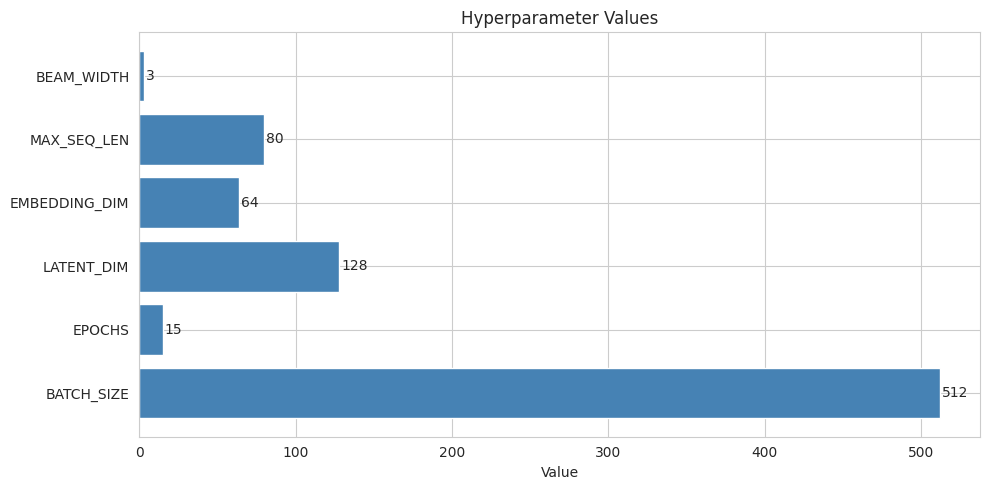

In [ ]:
hyperparams = {
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'LATENT_DIM': LATENT_DIM,
    'EMBEDDING_DIM': EMBEDDING_DIM,
    'MAX_SEQ_LEN': MAX_SEQ_LEN,
    'BEAM_WIDTH': BEAM_WIDTH
}

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(list(hyperparams.keys()), list(hyperparams.values()), color='steelblue')
ax.set_xlabel('Value')
ax.set_title('Hyperparameter Values')
for bar, val in zip(bars, hyperparams.values()):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, str(val), va='center')
plt.tight_layout()
plt.show()


---
## Load Data

Loads `train.csv`, `val.csv`, and `test.csv`. 


In [ ]:
def load_data(path, num_samples=None):
    """Load CSV and return (inputs, targets) with start/end tokens."""
    if not os.path.exists(path):
        print(f"⚠️ File not found: {path}")
        return [], []
    df = pd.read_csv(path)
    if num_samples:
        df = df.iloc[:num_samples]
    df = df.dropna()
    inputs = df['augmented_text'].astype(str).tolist()
    targets = ['\t' + txt + '\n' for txt in df['text'].astype(str).tolist()]
    return inputs, targets

print("load_data() function defined.")


load_data() function defined.


In [ ]:
train_input_texts, train_target_texts = load_data('/kaggle/input/spell-checker/train.csv', MAX_SAMPLES)
val_input_texts, val_target_texts = load_data('/kaggle/input/spell-checker/val.csv', 10000)
test_input_texts, test_target_texts = load_data('/kaggle/input/spell-checker/test.csv', 100)

if len(train_input_texts) == 0:
    print("⚠️ No training data found. Check that CSVs are in the same folder.")
else:
    print(f"✅ Training samples : {len(train_input_texts)}")
    print(f"✅ Validation samples: {len(val_input_texts)}")
    print(f"✅ Test samples      : {len(test_input_texts)}")


✅ Training samples : 100000
✅ Validation samples: 10000
✅ Test samples      : 100


---
### Visualize Dataset Sizes


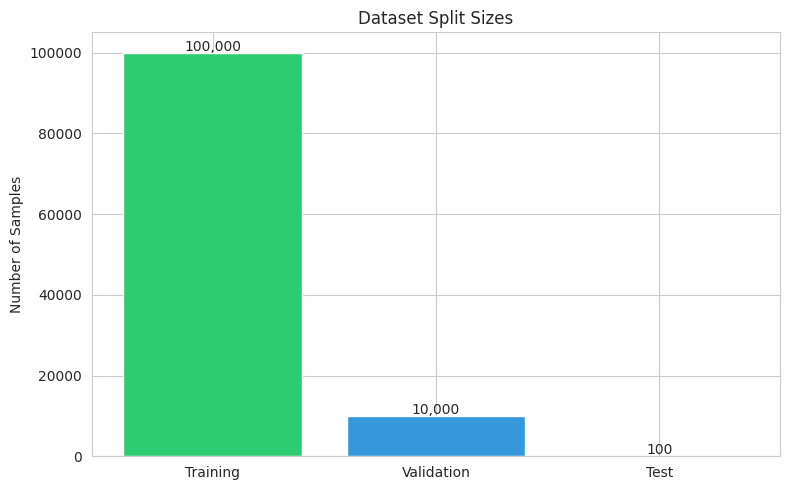

In [ ]:
dataset_sizes = {
    'Training': len(train_input_texts),
    'Validation': len(val_input_texts),
    'Test': len(test_input_texts)
}

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax.bar(dataset_sizes.keys(), dataset_sizes.values(), color=colors)
ax.set_ylabel('Number of Samples')
ax.set_title('Dataset Split Sizes')
for bar, val in zip(bars, dataset_sizes.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, f'{val:,}', ha='center')
plt.tight_layout()
plt.show()


In [ ]:
print("Sample data (first 3):")
for i in range(min(3, len(train_input_texts))):
    print(f"  Input : {train_input_texts[i]}")
    print(f"  Target: {train_target_texts[i].strip()}")
    print()


Sample data (first 3):
  Input : barbaric and shocking use of ofcre agaistn
  Target: barbaric and shocking use of force against

  Input : pm assy energy policy has laomst universal support
  Target: pm says energy policy has almost universal support

  Input : coronavirus tasmania peter gutwein econIjy JJpact
  Target: coronavirus tasmania peter gutwein economy impact



---
### Visualize Sample Length Distribution


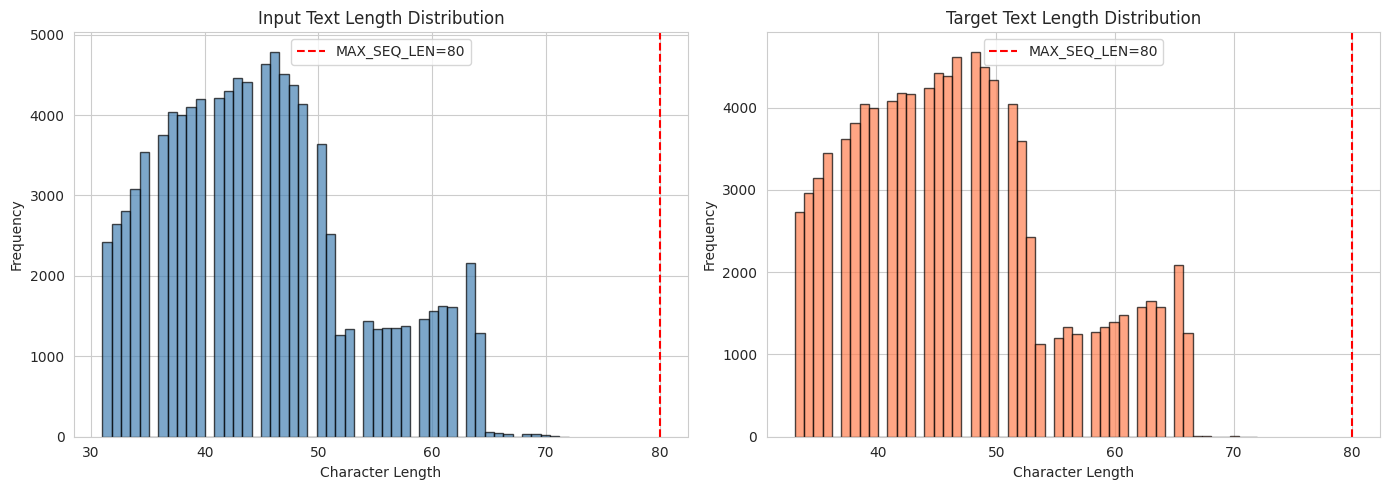

Input lengths  - Mean: 44.8, Max: 72, Min: 31
Target lengths - Mean: 46.5, Max: 72, Min: 33
Samples exceeding MAX_SEQ_LEN (80): 0


In [ ]:
input_lengths = [len(txt) for txt in train_input_texts]
target_lengths = [len(txt) for txt in train_target_texts]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(input_lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=MAX_SEQ_LEN, color='red', linestyle='--', label=f'MAX_SEQ_LEN={MAX_SEQ_LEN}')
axes[0].set_xlabel('Character Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Input Text Length Distribution')
axes[0].legend()

axes[1].hist(target_lengths, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(x=MAX_SEQ_LEN, color='red', linestyle='--', label=f'MAX_SEQ_LEN={MAX_SEQ_LEN}')
axes[1].set_xlabel('Character Length')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Target Text Length Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Input lengths  - Mean: {np.mean(input_lengths):.1f}, Max: {np.max(input_lengths)}, Min: {np.min(input_lengths)}")
print(f"Target lengths - Mean: {np.mean(target_lengths):.1f}, Max: {np.max(target_lengths)}, Min: {np.min(target_lengths)}")
print(f"Samples exceeding MAX_SEQ_LEN ({MAX_SEQ_LEN}): {sum(1 for l in input_lengths if l > MAX_SEQ_LEN)}")


---
## Tokenization




In [ ]:
tokenizer = Tokenizer(char_level=True, filters='')  # 
tokenizer.fit_on_texts(train_input_texts + train_target_texts + val_input_texts + val_target_texts)

vocab_size = len(tokenizer.word_index) + 1  
reverse_char_map = {i: char for char, i in tokenizer.word_index.items()}
target_token_index = tokenizer.word_index

print(f"✅ Vocabulary size: {vocab_size}")
print(f"   Sample char→index: {dict(list(tokenizer.word_index.items())[:10])}")


✅ Vocabulary size: 61
   Sample char→index: {' ': 1, 'e': 2, 'a': 3, 's': 4, 'r': 5, 'o': 6, 'i': 7, 't': 8, 'n': 9, 'l': 10}


---
### Visualize Character Vocabulary


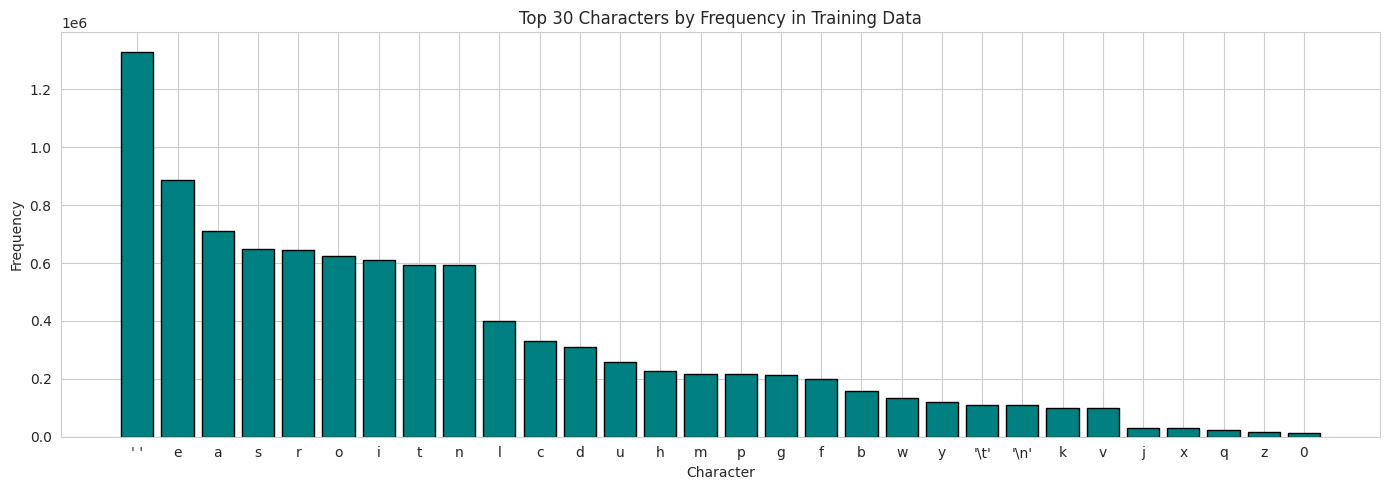

Total unique characters in vocabulary: 60


In [ ]:
char_counts = tokenizer.word_counts
sorted_chars = sorted(char_counts.items(), key=lambda x: x[1], reverse=True)[:30]

chars = [c[0] if c[0] not in ['\t', '\n', ' '] else repr(c[0]) for c in sorted_chars]
counts = [c[1] for c in sorted_chars]

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(chars, counts, color='teal', edgecolor='black')
ax.set_xlabel('Character')
ax.set_ylabel('Frequency')
ax.set_title('Top 30 Characters by Frequency in Training Data')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Total unique characters in vocabulary: {vocab_size - 1}")


---
## Preprocessing



In [ ]:
def preprocess_data(input_texts, target_texts):
    """Convert text lists to padded sequences for encoder and decoder."""
    encoder_seq = tokenizer.texts_to_sequences(input_texts)
    encoder_pad = pad_sequences(encoder_seq, maxlen=MAX_SEQ_LEN, padding='post')
    
    decoder_seq = tokenizer.texts_to_sequences(target_texts)
    decoder_pad = pad_sequences(decoder_seq, maxlen=MAX_SEQ_LEN, padding='post')
    
    target_seqs = [seq[1:] for seq in decoder_seq]
    target_pad = pad_sequences(target_seqs, maxlen=MAX_SEQ_LEN, padding='post')
    target_pad = np.expand_dims(target_pad, -1)  
    
    return encoder_pad, decoder_pad, target_pad

print("preprocess_data() function defined.")


preprocess_data() function defined.


In [ ]:
train_enc, train_dec, train_target = preprocess_data(train_input_texts, train_target_texts)
val_enc, val_dec, val_target = preprocess_data(val_input_texts, val_target_texts)

print(f"✅ Training data shapes:")
print(f"   Encoder input : {train_enc.shape}")
print(f"   Decoder input : {train_dec.shape}")
print(f"   Decoder target: {train_target.shape}")


✅ Training data shapes:
   Encoder input : (100000, 80)
   Decoder input : (100000, 80)
   Decoder target: (100000, 80, 1)


---
### Visualize Preprocessed Data Shapes


In [ ]:
shapes_data = {
    'Array': ['train_enc', 'train_dec', 'train_target', 'val_enc', 'val_dec', 'val_target'],
    'Shape': [str(train_enc.shape), str(train_dec.shape), str(train_target.shape),
              str(val_enc.shape), str(val_dec.shape), str(val_target.shape)],
    'Description': ['Encoder input (train)', 'Decoder input (train)', 'Decoder target (train)',
                    'Encoder input (val)', 'Decoder input (val)', 'Decoder target (val)']
}
shapes_df = pd.DataFrame(shapes_data)
print("Preprocessed Data Shapes:")
print(shapes_df.to_string(index=False))


Preprocessed Data Shapes:
       Array           Shape            Description
   train_enc    (100000, 80)  Encoder input (train)
   train_dec    (100000, 80)  Decoder input (train)
train_target (100000, 80, 1) Decoder target (train)
     val_enc     (10000, 80)    Encoder input (val)
     val_dec     (10000, 80)    Decoder input (val)
  val_target  (10000, 80, 1)   Decoder target (val)


In [ ]:
sample_idx = 0
print(f"Sample {sample_idx} visualization:")
print(f"  Original input : {train_input_texts[sample_idx]}")
print(f"  Encoded (first 20): {train_enc[sample_idx][:20]}")
print(f"  Original target: {train_target_texts[sample_idx].strip()}")
print(f"  Encoded (first 20): {train_dec[sample_idx][:20]}")


Sample 0 visualization:
  Original input : barbaric and shocking use of ofcre agaistn
  Encoded (first 20): [19  3  5 19  3  5  7 11  1  3  9 12  1  4 14  6 11 24  7  9]
  Original target: barbaric and shocking use of force against
  Encoded (first 20): [22 19  3  5 19  3  5  7 11  1  3  9 12  1  4 14  6 11 24  7]


---
## Build Model (Seq2Seq with Attention)

**Encoder**: Bidirectional LSTM reads noisy input

**Decoder**: LSTM generates corrected output

**Attention**: Helps decoder focus on relevant encoder positions


In [ ]:
def manual_attention(query, value):
    """Dot-product attention mechanism."""
    score = Dot(axes=[2, 2])([query, value])       
    attention_weights = Activation('softmax')(score)
    context_vector = Dot(axes=[2, 1])([attention_weights, value])  
    return context_vector

print("manual_attention() function defined.")


manual_attention() function defined.


In [ ]:
# --- ENCODER ---
encoder_inputs = Input(shape=(MAX_SEQ_LEN,), name='encoder_inputs')
enc_emb = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQ_LEN, mask_zero=True)(encoder_inputs)
encoder_lstm = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(enc_emb)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

print("✅ Encoder built")
print(f"   Encoder output shape: {encoder_outputs.shape}")
print(f"   State h shape: {state_h.shape}")


✅ Encoder built
   Encoder output shape: (?, 80, 256)
   State h shape: (?, 256)


In [ ]:
# --- DECODER ---
decoder_inputs = Input(shape=(MAX_SEQ_LEN,), name='decoder_inputs')
dec_emb_layer = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQ_LEN, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(LATENT_DIM * 2, return_sequences=True, return_state=True)  
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

print("✅ Decoder built")
print(f"   Decoder output shape: {decoder_outputs.shape}")


✅ Decoder built
   Decoder output shape: (?, 80, 256)


In [100]:
# --- ATTENTION + OUTPUT ---
attention_result = manual_attention(decoder_outputs, encoder_outputs)
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_result])

decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

print("✅ Attention and output layer built")
print(f"   Final output shape: {decoder_outputs.shape}")


✅ Attention and output layer built
   Final output shape: (?, 80, 61)


In [101]:
# --- COMPILE MODEL ---
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("✅ Model compiled")
model.summary()


✅ Model compiled
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 80)]                 0         []                            
 )                                                                                                
                                                                                                  
 embedding_6 (Embedding)     (None, 80, 64)               3904      ['encoder_inputs[0][0]']      
                                                                                                  
 decoder_inputs (InputLayer  [(None, 80)]                 0         []                            
 )                                                                                                
                                                                           

---
### Visualize Model Architecture Summary


Model Parameter Summary:
  Total parameters     : 565,437
  Trainable parameters : 565,437
  Non-trainable params : 0


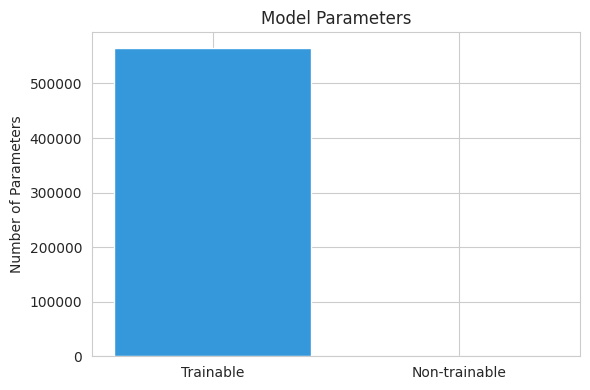

In [ ]:
# Count model parameters
total_params = model.count_params()
trainable_params = sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("Model Parameter Summary:")
print(f"  Total parameters     : {total_params:,}")
print(f"  Trainable parameters : {trainable_params:,}")
print(f"  Non-trainable params : {non_trainable_params:,}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(['Trainable', 'Non-trainable'], [trainable_params, non_trainable_params], color=['#3498db', '#95a5a6'])
ax.set_ylabel('Number of Parameters')
ax.set_title('Model Parameters')
plt.tight_layout()
plt.show()


---
## Training




In [103]:
# Callbacks
checkpoint = ModelCheckpoint(
    "best_speller_pro.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

print("✅ Callbacks ready (checkpoint + early stopping)")


✅ Callbacks ready (checkpoint + early stopping)


In [ ]:
history = model.fit(
    [train_enc, train_dec],
    train_target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([val_enc, val_dec], val_target),
    callbacks=[checkpoint, early_stopping]
)

print("\n✅ Training complete!")
print(f"   Best model saved to: best_speller_pro.h5")


Train on 100000 samples, validate on 10000 samples
Epoch 1/15
100000/100000 [==============================] - ETA: 0s - loss: 2.7410 - acc: 0.2008

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training_v1.py:2330: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 2.38113, saving model to best_speller_pro.h5


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100000/100000 [==============================] - 475s 5ms/sample - loss: 2.7410 - acc: 0.2008 - val_loss: 2.3811 - val_acc: 0.2874
Epoch 2/15
100000/100000 [==============================] - ETA: 0s - loss: 1.9589 - acc: 0.4175
Epoch 2: val_loss improved from 2.38113 to 1.09800, saving model to best_speller_pro.h5
100000/100000 [==============================] - 469s 5ms/sample - loss: 1.9589 - acc: 0.4175 - val_loss: 1.0980 - val_acc: 0.7270
Epoch 3/15
100000/100000 [==============================] - ETA: 0s - loss: 0.6607 - acc: 0.8435
Epoch 3: val_loss improved from 1.09800 to 0.48219, saving model to best_speller_pro.h5
100000/100000 [==============================] - 469s 5ms/sample - loss: 0.6607 - acc: 0.8435 - val_loss: 0.4822 - val_acc: 0.8853
Epoch 4/15
100000/100000 [==============================] - ETA: 0s - loss: 0.4209 - acc: 0.8952
Epoch 4: val_loss improved from 0.48219 to 0.36641, saving model to best_speller_pro.h5
100000/100000 [==============================] - 465

---
### Visualize Training Progress for Loss and Accuracy 


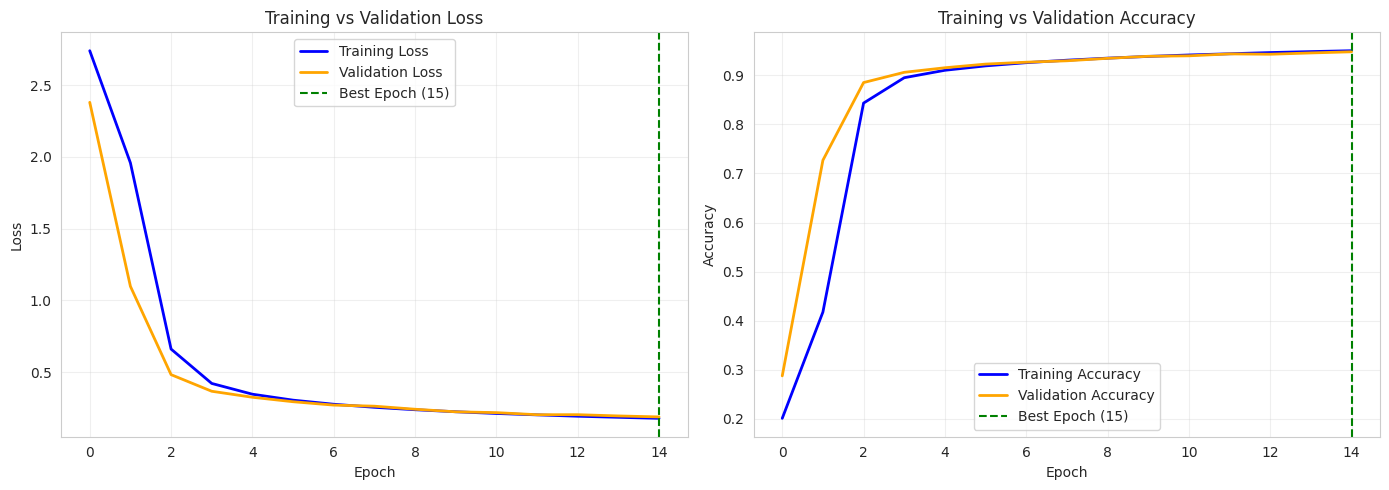

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
best_epoch = np.argmin(history.history['val_loss'])
axes[0].axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch + 1})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['acc'], label='Training Accuracy', color='blue', linewidth=2)
axes[1].plot(history.history['val_acc'], label='Validation Accuracy', color='orange', linewidth=2)
axes[1].axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch + 1})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Training metrics summary table
epochs_run = len(history.history['loss'])
metrics_data = {
    'Metric': ['Final Train Loss', 'Final Val Loss', 'Final Train Acc', 'Final Val Acc', 
               'Best Val Loss', 'Best Epoch', 'Epochs Run'],
    'Value': [
        f"{history.history['loss'][-1]:.4f}",
        f"{history.history['val_loss'][-1]:.4f}",
        f"{history.history['acc'][-1]:.4f}",       
        f"{history.history['val_acc'][-1]:.4f}",   
        f"{min(history.history['val_loss']):.4f}",
        f"{np.argmin(history.history['val_loss']) + 1}",
        f"{epochs_run}"
    ]
}
metrics_df = pd.DataFrame(metrics_data)
print("Training Metrics Summary:")
print(metrics_df.to_string(index=False))


Training Metrics Summary:
          Metric  Value
Final Train Loss 0.1776
  Final Val Loss 0.1874
 Final Train Acc 0.9503
   Final Val Acc 0.9481
   Best Val Loss 0.1874
      Best Epoch     15
      Epochs Run     15


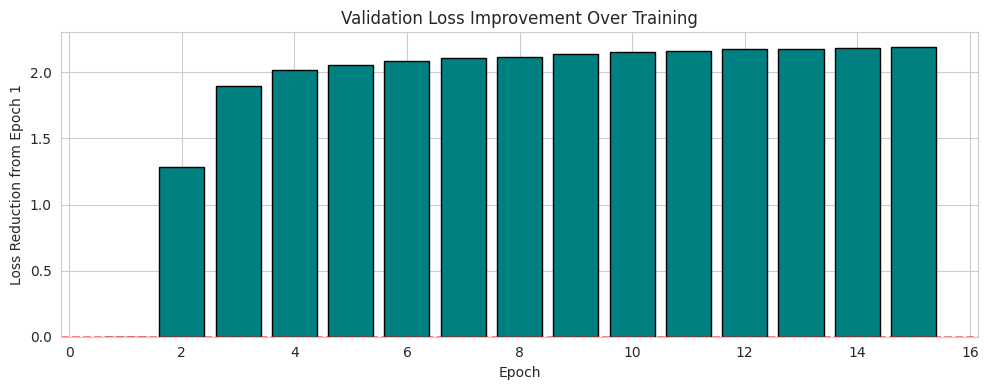

In [109]:
# Visualize improvement over epochs
improvement = [history.history['val_loss'][0] - v for v in history.history['val_loss']]

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(1, len(improvement) + 1), improvement, color='teal', edgecolor='black')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss Reduction from Epoch 1')
ax.set_title('Validation Loss Improvement Over Training')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


---
## Training History Loss Curves


In [ ]:
import numpy as np

# Print training history
print("Training History:")
print(f"  Final train loss: {history.history['loss'][-1]:.4f}")
print(f"  Final val loss  : {history.history['val_loss'][-1]:.4f}")
print(f"  Final train acc : {history.history['acc'][-1]:.4f}")
print(f"  Final val acc   : {history.history['val_acc'][-1]:.4f}")
print(f"  Best epoch      : {np.argmin(history.history['val_loss']) + 1}")


Training History:
  Final train loss: 0.1776
  Final val loss  : 0.1874
  Final train acc : 0.9503
  Final val acc   : 0.9481
  Best epoch      : 15


---
## Build Inference Models




In [ ]:
encoder_model_inf = Model(encoder_inputs, [encoder_outputs] + encoder_states)

print("✅ Encoder inference model built")


✅ Encoder inference model built


In [ ]:
# --- DECODER INFERENCE MODEL ---
decoder_state_input_h = Input(shape=(LATENT_DIM * 2,))
decoder_state_input_c = Input(shape=(LATENT_DIM * 2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_inf = Input(shape=(1,))  
dec_emb_inf = dec_emb_layer(decoder_inputs_inf)

decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(dec_emb_inf, initial_state=decoder_states_inputs)
decoder_states_inf = [state_h_inf, state_c_inf]

encoder_outputs_input = Input(shape=(MAX_SEQ_LEN, LATENT_DIM * 2))
attention_result_inf = manual_attention(decoder_outputs_inf, encoder_outputs_input)
decoder_concat_inf = Concatenate(axis=-1)([decoder_outputs_inf, attention_result_inf])
decoder_outputs_inf = decoder_dense(decoder_concat_inf)

decoder_model_inf = Model(
    [decoder_inputs_inf, decoder_state_input_h, decoder_state_input_c, encoder_outputs_input],
    [decoder_outputs_inf] + decoder_states_inf
)

print("✅ Decoder inference model built")


✅ Decoder inference model built


---
## Helper Functions for Inference


In [114]:
def restore_numbers(original_text, pred_text):
    """
    Keep numbers from original text stable.
    Prevents '3600' from becoming '3500'.
    """
    input_nums = re.findall(r'\d+', original_text)
    pred_nums = re.findall(r'\d+', pred_text)
    
    if len(input_nums) > 0 and len(input_nums) == len(pred_nums):
        for i in range(len(input_nums)):
            pred_text = pred_text.replace(pred_nums[i], input_nums[i], 1)
    return pred_text

print("restore_numbers() function defined.")


restore_numbers() function defined.


In [ ]:
def beam_search_decode(input_text, k=BEAM_WIDTH):
    """
    Beam search decoding: explores top-k candidates at each step.
    Returns the most likely corrected text.
    """
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_pad = pad_sequences(input_seq, maxlen=MAX_SEQ_LEN, padding='post')
    
    # Encode input
    enc_outs, h, c = encoder_model_inf.predict(input_pad)
    
    
    start_token = target_token_index['\t']
    beams = [[0.0, "", start_token, h, c]]
    
    for _ in range(MAX_SEQ_LEN):
        all_candidates = []
        
        for b in beams:
            score, seq, last_tok, st_h, st_c = b
            
            
            if len(seq) > 0 and seq[-1] == '\n':
                all_candidates.append(b)
                continue
            
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = last_tok
            
            
            probs, new_h, new_c = decoder_model_inf.predict([target_seq, st_h, st_c, enc_outs])
            probs = probs[0, -1, :]
            
            
            top_indices = np.argsort(probs)[-k:]
            
            for idx in top_indices:
                p = probs[idx]
                if p < 1e-10:
                    continue
                new_score = score + math.log(p)
                char = reverse_char_map.get(idx, '')
                new_seq = seq + char
                all_candidates.append([new_score, new_seq, idx, new_h, new_c])
        
        
        beams = sorted(all_candidates, key=lambda x: x[0], reverse=True)[:k]
        
        
        if all(b[1].endswith('\n') for b in beams):
            break
    
    best_seq = beams[0][1].strip()
    final_seq = restore_numbers(input_text, best_seq)
    return final_seq

print("beam_search_decode() function defined.")


beam_search_decode() function defined.


---
## Test Predictions



In [116]:
print(f"Testing with Beam Search (Width={BEAM_WIDTH})\n")
print("=" * 60)

for i in range(min(5, len(test_input_texts))):
    input_txt = test_input_texts[i]
    correct_txt = test_target_texts[i].strip()
    
    try:
        pred_txt = beam_search_decode(input_txt)
        
        print(f"Input   : {input_txt}")
        print(f"Predicted: {pred_txt}")
        print(f"Correct : {correct_txt}")
        print(f"Match   : {'✅' if pred_txt == correct_txt else '❌'}")
        print("-" * 60)
    except Exception as e:
        print(f"Error on sample {i}: {e}")


Testing with Beam Search (Width=3)



/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training_v1.py:2354: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Input   : project looks to muelsnig ngeetic alternative
Predicted: project looks to melsing neetic alternative
Correct : project looks to mulesing genetic alternative
Match   : ❌
------------------------------------------------------------
Input   : chemical agents used during LrotWst at port ahgusra prixoj
Predicted: chemical agents used during protest at port aghusra prison
Correct : chemical agents used during protest at port augusta prison
Match   : ❌
------------------------------------------------------------
Input   : business hcmaber seeks budget infrastrcutuer boost
Predicted: business chamber seeks budget infrastructure boost
Correct : business chamber seeks budget infrastructure boost
Match   : ✅
------------------------------------------------------------
Input   : 3600 trips made to adrwni tip after cyconle
Predicted: 3600 trips made to darwin tip after cyconel
Correct : 3600 trips made to darwin tip after cyclone
Match   : ❌
-----------------------------------------------

---
### Visualize Test Results


In [ ]:
# Run evaluation on more test samples and calculate metrics
num_test = min(20, len(test_input_texts))
results = []

print("Running evaluation on test samples...")
for i in range(num_test):
    input_txt = test_input_texts[i]
    correct_txt = test_target_texts[i].strip()
    
    try:
        pred_txt = beam_search_decode(input_txt)
        exact_match = pred_txt == correct_txt
        results.append({
            'input': input_txt,
            'predicted': pred_txt,
            'correct': correct_txt,
            'exact_match': exact_match
        })
    except Exception as e:
        results.append({
            'input': input_txt,
            'predicted': f'ERROR: {e}',
            'correct': correct_txt,
            'exact_match': False
        })

print(f"✅ Evaluated {len(results)} samples")


Running evaluation on test samples...
✅ Evaluated 20 samples


Exact Match Accuracy: 2/20 = 10.0%


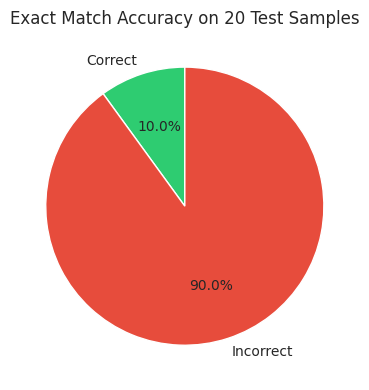

In [118]:
# Calculate accuracy metrics
exact_matches = sum(1 for r in results if r['exact_match'])
accuracy = exact_matches / len(results) * 100

print(f"Exact Match Accuracy: {exact_matches}/{len(results)} = {accuracy:.1f}%")

# Visualize accuracy
fig, ax = plt.subplots(figsize=(6, 4))
ax.pie([exact_matches, len(results) - exact_matches], 
       labels=['Correct', 'Incorrect'], 
       colors=['#2ecc71', '#e74c3c'],
       autopct='%1.1f%%',
       startangle=90)
ax.set_title(f'Exact Match Accuracy on {len(results)} Test Samples')
plt.tight_layout()
plt.show()


In [119]:
# Calculate Character Error Rate (CER)
def calculate_cer(predicted, target):
    """Calculate Character Error Rate using Levenshtein distance"""
    if len(target) == 0:
        return 1.0 if len(predicted) > 0 else 0.0
    
    # Simple Levenshtein distance
    m, n = len(predicted), len(target)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if predicted[i-1] == target[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1]) + 1
    
    return dp[m][n] / len(target)

cer_scores = [calculate_cer(r['predicted'], r['correct']) for r in results]
avg_cer = np.mean(cer_scores)

print(f"Character Error Rate (CER): {avg_cer:.4f} ({avg_cer * 100:.2f}%)")
print(f"Lower is better (0 = perfect)")


Character Error Rate (CER): 0.0822 (8.22%)
Lower is better (0 = perfect)


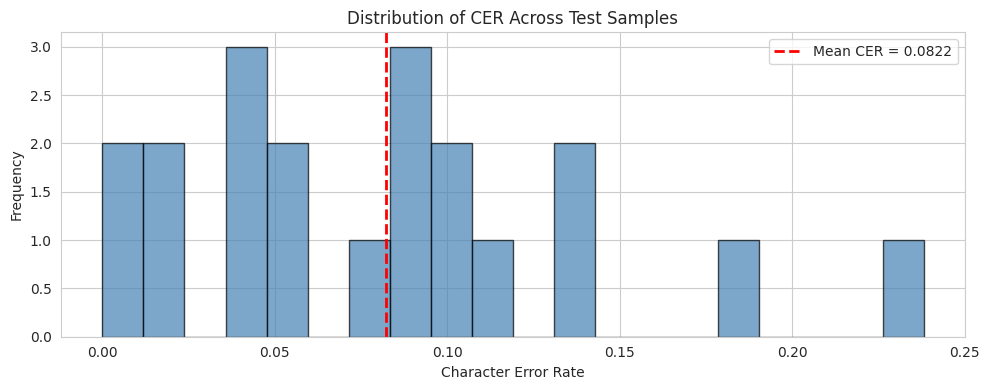

In [121]:
# Visualize CER distribution
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(cer_scores, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(x=avg_cer, color='red', linestyle='--', linewidth=2, label=f'Mean CER = {avg_cer:.4f}')
ax.set_xlabel('Character Error Rate')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of CER Across Test Samples')
ax.legend()
plt.tight_layout()
plt.show()


In [122]:
# Show detailed results table
results_df = pd.DataFrame(results)
results_df['cer'] = cer_scores
results_df['status'] = results_df['exact_match'].apply(lambda x: '✅' if x else '❌')

print("Detailed Test Results (first 10):")
print(results_df[['input', 'predicted', 'correct', 'status', 'cer']].head(10).to_string(index=False))


Detailed Test Results (first 10):
                                                      input                                                  predicted                                                     correct status      cer
              project looks to muelsnig ngeetic alternative                project looks to melsing neetic alternative               project looks to mulesing genetic alternative      ❌ 0.088889
 chemical agents used during LrotWst at port ahgusra prixoj chemical agents used during protest at port aghusra prison  chemical agents used during protest at port augusta prison      ❌ 0.051724
         business hcmaber seeks budget infrastrcutuer boost         business chamber seeks budget infrastructure boost          business chamber seeks budget infrastructure boost      ✅ 0.000000
                3600 trips made to adrwni tip after cyconle                3600 trips made to darwin tip after cyconel                 3600 trips made to darwin tip after cyclone      ❌ 

---
### Final Metrics Summary


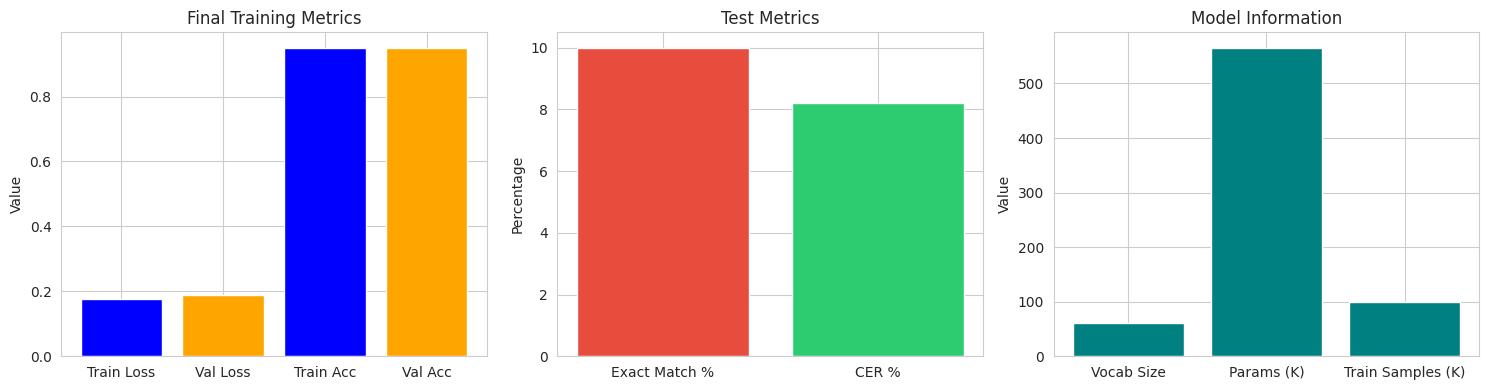


TRAINING COMPLETE - SUMMARY
Model saved to: best_speller_pro.h5
Tokenizer saved to: tokenizer.pickle
Test Exact Match: 10.0%
Test CER: 8.22%


In [ ]:
import matplotlib.pyplot as plt

acc_key = 'acc' if 'acc' in history.history else 'accuracy'
val_acc_key = 'val_acc' if 'val_acc' in history.history else 'val_accuracy'

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

train_metrics = ['Train Loss', 'Val Loss', 'Train Acc', 'Val Acc']
train_values = [
    history.history['loss'][-1], 
    history.history['val_loss'][-1],
    history.history[acc_key][-1], 
    history.history[val_acc_key][-1]
]
axes[0].bar(train_metrics, train_values, color=['blue', 'orange', 'blue', 'orange'])
axes[0].set_title('Final Training Metrics')
axes[0].set_ylabel('Value')


final_acc = accuracy if 'accuracy' in locals() else 0
final_cer = avg_cer if 'avg_cer' in locals() else 0

test_metrics = ['Exact Match %', 'CER %']
test_values = [final_acc, final_cer * 100]
colors = ['#2ecc71' if final_acc > 50 else '#e74c3c', 
          '#2ecc71' if final_cer < 0.1 else '#e74c3c']
axes[1].bar(test_metrics, test_values, color=colors)
axes[1].set_title('Test Metrics')
axes[1].set_ylabel('Percentage')


params_count = model.count_params() if 'model' in locals() else 0
samples_count = len(train_input_texts) if 'train_input_texts' in locals() else 100000

info_labels = ['Vocab Size', 'Params (K)', 'Train Samples (K)']
info_values = [vocab_size, params_count/1000, samples_count/1000]
axes[2].bar(info_labels, info_values, color='teal')
axes[2].set_title('Model Information')
axes[2].set_ylabel('Value')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TRAINING COMPLETE - SUMMARY")
print("="*60)
print(f"Model saved to: best_speller_pro.h5")
print(f"Tokenizer saved to: tokenizer.pickle")
print(f"Test Exact Match: {final_acc:.1f}%")
print(f"Test CER: {final_cer*100:.2f}%")
print("="*60)


---
## Save Tokenizer




In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ tokenizer.pickle saved!")
print("\nYou can now run app.py to start the web server.")


✅ tokenizer.pickle saved!

You can now run app.py to start the web server.


---
---
